# Import Required Libraries.

In [0]:
from __future__ import print_function
from __future__ import absolute_import
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.layers import Input
from keras.optimizers import Adam
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.preprocessing import image
from imgaug import augmenters as iaa
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs
from keras.layers import GlobalMaxPooling1D, Dense, Conv1D,Conv2D
from keras import regularizers,optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (merge, Lambda)
from keras.layers.convolutional import (Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D)
import matplotlib.pyplot as plt
import random as random
import warnings,gc,csv,keras,os,sys
import imgaug as ia
import pandas as pd
import numpy as np
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K
sys.setrecursionlimit(10000)

Using TensorFlow backend.


# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Download & Load Data And Labels

In [0]:
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

--2020-06-03 10:05:37--  http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6087523606 (5.7G) [application/zip]
Saving to: ‘MRNet-v1.0.zip’

MRNet-v1.0.zip      100%[===================>]   5.67G  2.01MB/s    in 48m 2s  

2020-06-03 10:53:39 (2.01 MB/s) - ‘MRNet-v1.0.zip’ saved [6087523606/6087523606]



# Unzip Data Inside The Drive

In [0]:
#!cp -r '/content/MRNet-v1.0.zip' '/content/drive/My Drive/MRNET/' 
%cd /content/drive/My Drive/MRNET/
!unzip MRNet-v1.0.zip

Archive:  MRNet-v1.0.zip
warning [MRNet-v1.0.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
replace MRNet-v1.0/valid-abnormal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MRNet-v1.0/valid/axial/1139.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
file #2547:  bad zipfile offset (local header sig):  1353202
  (attempting to re-compensate)


# Main And Helper Functions

In [0]:
def augment(image):
  aug=[]
  for s in range(len(image)):
      aug.append(ia.imresize_single_image(image[s], (227, 227)))
  aug=np.array(aug)
  return aug

def clear():
  aug= None
  gc.collect()

# To add the third channel(to color the image).
def add_rgb(grey_img):
  rgb_img = np.repeat(grey_img[..., np.newaxis], 3, -1)
  return rgb_img

# Load data, to skip metadata file.
def load_data(path):
  data = []
  for d in sorted(os.listdir(path)):
    if d!='.DS_Store':
      data.append(d)
      print("in iterator ", d)
      clear()
  return data

# Load labels from CSV files.  
def load_labels(path):
  labels = []
  read = pd.read_csv(path, names=['num', 'hot'])
  labels = list(read['hot'])
  return labels

def plot_graphs(y):
  plt.plot( epochs,y.history['acc'],'r')
  plt.xlabel("Epochs")
  plt.ylabel("acc")
  plt.title("Accuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_acc'],'b')
  plt.xlabel("Epochs")
  plt.ylabel("val_acc")
  plt.title("Vlidation Acuuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['loss'],'g')
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.title("Loss vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_loss'],'k')
  plt.xlabel("Epochs")
  plt.ylabel("val_loss")
  plt.title("Validation Loss vs Epochs")
  plt.show()

#Hyperparameters 
def Average(lst): 
    return sum(lst) / len(lst) 

# Loop over dataset for 300 times.
epoch=300
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

# Load Train Data And Labels Directories "From Drive"

In [0]:
#Load Data
train_axial_dir='/content/drive/My Drive/MRNET/MRNet-v1.0/train/axial'
train_coronal_dir= '/content/drive/My Drive/MRNET/MRNet-v1.0/train/coronal'
train_sagittal_dir= '/content/drive/My Drive/MRNET/MRNet-v1.0/train/sagittal'

train_abnormal_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/train-abnormal.csv'
train_acl_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/train-acl.csv'
train_meniscus_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/train-meniscus.csv'

# Load Train Data And Labels "From Drive"

In [0]:
print("##############     Load Axial Data   ##############")
train_axial_data = os.listdir(train_axial_dir)

print("##############     Load Cronal Data   ##############")
train_coronal_data = os.listdir(train_coronal_dir)

print("##############     Load Sagital Data   ##############")
train_sagittal_data = os.listdir(train_sagittal_dir)

print("##############  Load Abnormal Labels   ##############")
train_abnormal_labels = load_labels(train_abnormal_labels)

print("##############  Load ACL Labels   ##############")
train_acl_labels = load_labels(train_acl_labels)

print("##############  Load Meniscus Labels   ##############")
train_meniscus_labels = load_labels(train_meniscus_labels)

##############     Load Axial Data   ##############
##############     Load Cronal Data   ##############
##############     Load Sagital Data   ##############
##############  Load Abnormal Labels   ##############
##############  Load ACL Labels   ##############
##############  Load Meniscus Labels   ##############


# Load Validiation Data And Labels Directories & Data "From Drive"

In [0]:

val_axial_dir = '/content/drive/My Drive/MRNET/MRNet-v1.0/valid/axial'
val_coronal_dir = '/content/drive/My Drive/MRNET/MRNet-v1.0/valid/coronal'
val_sagittal_dir = '/content/drive/My Drive/MRNET/MRNet-v1.0/valid/sagittal'

val_abnormal_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/valid-abnormal.csv'
val_acl_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/valid-acl.csv'
val_meniscus_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/valid-meniscus.csv'

val_axial_data = os.listdir(val_axial_dir)
val_coronal_data = os.listdir(val_coronal_dir)
val_sagittal_data =  os.listdir(val_sagittal_dir)


val_abnormal_labels= load_labels(val_abnormal_labels)
val_meniscus_labels= load_labels(val_meniscus_labels)
val_acl_labels= load_labels(val_acl_labels)


# MRNET Implementation Using AlexNet As Feature Extractor

In [0]:
#MRNet - Model
ALEXNet = Sequential()

# 1st Convolutional Layer
ALEXNet.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
ALEXNet.add(Activation('relu'))

# Max Pooling
ALEXNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
ALEXNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# Max Pooling
ALEXNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
ALEXNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# 4th Convolutional Layer
ALEXNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# 5th Convolutional Layer
ALEXNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# To build avg_pooling cnn layers.
average_pool = Sequential()
average_pool.add(layers.AveragePooling2D())
average_pool.add(layers.Flatten())
# To use alex net as feature extractor.
#average_pool.add(layers.Dense(1, activation='sigmoid'))

# Bild MRNET.
MRNet = Sequential([
    ALEXNet, 
    average_pool])

# Maxpooling
MRNet.add(Dense(256, activation ='relu',kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0)))
MRNet.add(Dense(1, activation ='sigmoid'))
# stochastic gradient descent
sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

ALEXNet.summary()
average_pool.summary()
MRNet.summary()

MRNet.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_867 (Conv2D)          (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_862 (Activation)  (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_868 (Conv2D)          (None, 23, 23, 256)       614656    
_________________________________________________________________
activation_863 (Activation)  (None, 23, 23, 256)       0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_869 (Conv2D)          (None, 9, 9, 384)       

# Data Generation

In [0]:
# Training Data length
axialt_length = len(train_axial_data)
coronalt_length = len(train_coronal_data)
saggitalt_length= len(train_sagittal_data)

# Validiation Data length
axialv_length = len(val_axial_data)
coronalv_length = len(val_coronal_data)
saggitalv_length = len(val_sagittal_data)

# Data Generation and Shuffle Method.
def data_gen(data,label,path,data_length):
  all_data = list(zip(data,label))
  random.shuffle(all_data)
  i = 0
  while(True):
    if(i == data_length):
      yield(None,None)
      break
    for pair in all_data:
      if(pair[0] != '.DS_Store'):
        img = np.load(os.path.join(path,pair[0]),allow_pickle=True)
        img = img.astype(np.uint8)
        img_aug = augment(img)
        img_aug = add_rgb(img_aug)
        yield (img_aug,np.repeat(pair[1],img_aug.shape[0]))
    i += 1

# Data Generation For Abnormal Training Data {axial-coronal-sagittal}
axial_abnormal = data_gen(train_axial_data , train_abnormal_labels,train_axial_dir,axialt_length)
coronal_abnormal = data_gen(train_coronal_data,train_abnormal_labels,train_coronal_dir,coronalt_length)
sagittal_abnormal= data_gen(train_sagittal_data,train_abnormal_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For Abnormal Validiation Data {axial-coronal-sagittal}
axial_abnormal_val = data_gen(train_axial_data , val_abnormal_labels,train_axial_dir,axialv_length)
coronal_abnormal_val = data_gen(train_coronal_data , val_abnormal_labels,train_axial_dir,coronalv_length)
sagittal_abnormal_val = data_gen(train_sagittal_data , val_abnormal_labels,train_axial_dir,saggitalv_length)
# Data Generation For Acl Training Data {axial-coronal-sagittal}
axial_acl = data_gen(train_axial_data , train_acl_labels,train_axial_dir,axialt_length)
coronal_acl = data_gen(train_coronal_data,train_acl_labels,train_coronal_dir,coronalt_length)
sagittal_acl = data_gen(train_sagittal_data,train_acl_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For ACL Validiation Data {axial-coronal-sagittal}
axial_acl_val = data_gen(train_axial_data , val_acl_labels,train_axial_dir,axialv_length)
coronal_acl_val = data_gen(train_coronal_data , val_acl_labels,train_axial_dir,coronalv_length)
sagittal_acl_val = data_gen(train_sagittal_data , val_acl_labels,train_axial_dir,saggitalv_length)
# Data Generation For Meniscus Training Data {axial-coronal-sagittal}
axial_meniscus = data_gen(train_axial_data , train_meniscus_labels,train_axial_dir,axialt_length)
coronal_meniscus = data_gen(train_coronal_data,train_meniscus_labels,train_coronal_dir,coronalt_length)
sagittal_meniscus = data_gen(train_sagittal_data,train_meniscus_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For Meniscus Validiation Data {axial-coronal-sagittal}
axial_meniscus_val = data_gen(train_axial_data , val_meniscus_labels,train_axial_dir,axialv_length)
coronal_meniscus_val = data_gen(train_coronal_data , val_meniscus_labels,train_axial_dir,coronalv_length)
sagittal_meniscus_val = data_gen(train_sagittal_data , val_meniscus_labels,train_axial_dir,saggitalv_length)


# Abnormal Training With MRNET.

In [0]:
abnormalAccuracys=[]
axial_abnormal = MRNet.fit(axial_abnormal, epochs = 300,steps_per_epoch= axialt_length,validation_data= axial_abnormal_val,validation_steps=axialv_length)
abnormalAccuracys.append(Average(axial_abnormal.history['val_acc']))
plot_graphs(axial_abnormal)

In [0]:
coronal_abnormal = MRNet.fit(coronal_abnormal, epochs = 300,steps_per_epoch= coronalt_length,validation_data= coronal_abnormal_val,validation_steps=coronalv_length )
abnormalAccuracys.append(Average(coronal_abnormal.history['val_acc']))
plot_graphs(coronal_abnormal)

In [0]:
sagittal_abnormal = MRNet.fit(sagittal_abnormal, epochs = 300,steps_per_epoch= saggitalt_length,validation_data= sagittal_abnormal_val,validation_steps=saggitalv_length )
abnormalAccuracys.append(Average(sagittal_abnormal.history['val_acc']))
plot_graphs(sagittal_abnormal)

# ACL Training With MRNET.

In [0]:
aclAccuracys=[]
axial_acl = MRNet.fit(axial_acl, epochs = 300,steps_per_epoch= axialt_length,validation_data= axial_acl_val,validation_steps=axialv_length)
aclAccuracys.append(Average(axial_acl.history['val_acc'])) 
plot_graphs(axial_acl)

In [0]:
coronal_acl = MRNet.fit(coronal_acl, epochs = 300,steps_per_epoch= coronalt_length,validation_data= coronal_acl_val,validation_steps=coronalv_length )
abnormalAccuracys.append(Average(coronal_acl.history['val_acc']))
plot_graphs(coronal_acl)

In [0]:
sagittal_acl = MRNet.fit(sagittal_acl, epochs = 300,steps_per_epoch= saggitalt_length,validation_data= sagittal_acl_val,validation_steps=saggitalv_length )
abnormalAccuracys.append(Average(sagittal_acl.history['val_acc']))
plot_graphs(sagittal_acl)

# Meniscus Training With MRNET.

In [0]:
meniscusAccuracys=[]
axial_meniscus = MRNet.fit(axial_meniscus, epochs = 300,steps_per_epoch= axialt_length,validation_data= axial_meniscus_val,validation_steps=axialv_length)
meniscusAccuracys.append(Average(axial_meniscus.history['val_acc'])) 
plot_graphs(axial_meniscus)

In [0]:
coronal_meniscus = MRNet.fit(coronal_meniscus, epochs = 300,steps_per_epoch= axialt_length,validation_data= coronal_meniscus_val,validation_steps=coronalv_length)
meniscusAccuracys.append(Average(coronal_meniscus.history['val_acc'])) 
plot_graphs(coronal_meniscus)

In [0]:
sagittal_meniscus = MRNet.fit(sagittal_meniscus, epochs = 300,steps_per_epoch= axialt_length,validation_data= sagittal_meniscus_val,validation_steps=saggitalv_length)
meniscusAccuracys.append(Average(sagittal_meniscus.history['val_acc'])) 
plot_graphs(sagittal_meniscus)

# VGG Model Implementation With Compilation

In [0]:
vggModel = Sequential()
vggModel.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vggModel.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Flatten())
vggModel.add(Dense(units=4096,activation="relu"))
vggModel.add(Dense(units=4096,activation="relu"))
vggModel.add(Dense(units=2, activation="softmax"))
from keras.optimizers import Adam
opt = Adam(lr=0.001)
vggModel.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
vggModel.summary()


# InceptionV3 Model Implementation 

In [0]:
# Pre-Trained Weights For the Inception V3.
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


def InceptionV3(include_top=True, input_tensor=None, input_shape=None, pooling=None, classes=1000):
    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=139,
        data_format=K.image_data_format(),
        require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = Input(tensor=input_tensor, shape=input_shape)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)
    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)
    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)
    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')
    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis, name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)
        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
        branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis, name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis, name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3, strides=(2, 2), padding='valid')
    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')
    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)
        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate([branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))
        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)
        branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed' + str(9 + i))
    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    model = Model(inputs, x, name='inception_v3')
    return model

# InceptionV3 Model Compilation

In [0]:
model = InceptionV3()
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()
#coronal_abnormal = model.fit(coronal_abnormal, epochs = 300,steps_per_epoch= coronalt_length,validation_data= coronal_abnormal_val,validation_steps=coronalv_length )
# abnormalAccuracys.append(Average(coronal_abnormal.history['val_acc']))
# plot_graphs(coronal_abnormal)


# ResNet50 Model Implementation

In [0]:
# Pre-Trained Weights For the ResNet50.
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size, padding='same',name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(include_top=True, input_tensor=None, input_shape=None, pooling=None, classes=1000):
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=197, data_format=K.image_data_format(), require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')
    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH, cache_subdir='models', md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', WEIGHTS_PATH_NO_TOP, cache_subdir='models', md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('Warning')
    return model
    

In [0]:
model = ResNet50()
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

# Part 2: Using Built-In Models To Train The DataSet

###**Pre-trained Model NASNet, InceptionV3, VGG16 and ResNet50 for image classification**

In [0]:
# NASNetMobile
#include_top: Whether to include the fully-connected layer at the top of the network.
#input_shape: Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
#for NASNetMobile It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (224, 224, 3) would be one valid value.
model = keras.applications.nasnet.NASNetMobile(input_shape=None, include_top=False, weights='imagenet', input_tensor=None, pooling='avg')

# InceptionV3
#include_top: Boolean, whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
#input_shape: Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) 
#(with channels_last data format) or (3, 299, 299) (with channels_first data format). 
#It should have exactly 3 inputs channels, and width and height should be no smaller than 75. E.g. 
#(150, 150, 3) would be one valid value. input_shape will be ignored if the input_tensor is provided.
model2 = keras.applications.InceptionV3(include_top = False, input_shape = (256, 256, 3))

# VGG16
#include_top: whether to include the 3 fully-connected layers at the top of the network.
#input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) 
#(with channels_last data format) or (3, 224, 224) (with channels_first data format). 
#It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
model3 = keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=None, input_shape=(256, 256, 3))

# ResNet50
#include_top: whether to include the fully-connected layer at the top of the network.
#input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) 
#(with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). 
#It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
model4 = keras.applications.ResNet50( include_top=False, weights="imagenet", input_tensor=None, input_shape=(256, 256, 3))

#Models Summary
model.summary()
model2.summary()
model3.summary()
model4.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1317 (Activation)    (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________

In [0]:
#load the training data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def trainingSet(file_name):
    training_set = []
    for np_name in sorted(glob.glob('/content/drive/My Drive/MRNET/MRNet-v1.0/train/'+file_name+'/*.npy')):
        training_set.append(np.load(np_name))
    return training_set    

In [0]:
#as each exam (stack) contains S slices and most of the pretrained CNN models accept the image with channel = 3
#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [0]:
#load the training data for each angle of the knee
training_set_axial= trainingSet('axial')
training_set_coronal=trainingSet('coronal')
training_set_sagittal=trainingSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
training_set_axial = extract_3(training_set_axial, 1130)
training_set_coronal =extract_3(training_set_coronal, 1130)
training_set_sagittal =extract_3(training_set_sagittal, 1130)

In [0]:
training_set_axial.shape

(1130, 256, 256, 3)

In [0]:
#load the labels of one knee tear(abnormal | acl | meniscus) by the giving the file name that contains the labels
def load_labels2(train_file_name):
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    return training_labels

In [0]:
#load the labels of the trainig data for each knee tear 
training_label_abnormal = load_labels2('/content/drive/My Drive/MRNET/MRNet-v1.0/train-abnormal.csv')
training_label_acl = load_labels2('/content/drive/My Drive/MRNET/MRNet-v1.0/train-acl.csv')
training_label_meniscus = load_labels2('/content/drive/My Drive/MRNET/MRNet-v1.0/train-meniscus.csv')

In [0]:
training_label_acl.shape

(1130,)

In [0]:
from keras.applications.inception_v3 import InceptionV3

mri_InceptionV3 = InceptionV3(include_top = False, input_shape = (256, 256, 3))

#remove the last one
mri_InceptionV3.layers.pop()

#get the output of the INCEPTIONV# model "feature extraction" and add Dense layers so that the model is designed
#to classify our data
mri_InceptionV3_output = mri_InceptionV3.output

mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

mri_InceptionV3_last_layer = Dense(1024, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(128, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(32, activation = 'relu')(mri_InceptionV3_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

modified_mri_InceptionV3 = Model(inputs = mri_InceptionV3.input, output = predictor)

modified_mri_InceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
#freeze the added dense layers and unfreeze the rest:
for layer in modified_mri_InceptionV3.layers[15:]:
    layer.trainable = True 
    
for layer in mri_InceptionV3.layers:
    layer.trainable = False
    
modified_mri_InceptionV3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        print ('-val_f1 : %f '%(_val_f1))
        return
metrics = Metrics()

In [0]:
def plot_history(history):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='validation error')
    plt.plot(history.epoch, history.history['acc'], label='accuracy')
    plt.plot(history.epoch, history.history['val_acc'], label='validation accuracy')
    plt.plot(metrics.val_f1s, label='f_score')
    plt.grid(True,color='white')
    mpl.style.use('seaborn')
    plt.legend() 
          

In [0]:
#train the model with 1073 trainning data & 57 validation data
#save the model that has the max validation accuracy
#at the end plot the trainng loss & accuracy, validation loss & accuracy & F-score 
def fit_model2(training_set, training_labels, model_file_name):
  
    history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.05,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_acc', save_best_only=True, mode='max', period=1), metrics])
    plot_history(history)
    best_model = load_model(model_file_name)
    return best_model

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 51s 48ms/step - loss: 0.7450 - acc: 0.7409 - val_loss: 1.9503 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 2/30
1073/1073 [==============================] - 7s 6ms/step - loss: 0.5043 - acc: 0.7894 - val_loss: 1.2111 - val_acc: 0.8246
-val_f1 : 0.903846 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4911 - acc: 0.7829 - val_loss: 2.3140 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5190 - acc: 0.7866 - val_loss: 0.9788 - val_acc: 0.7193
-val_f1 : 0.833333 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3996 - acc: 0.8257 - val_loss: 2.2516 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3655 - acc: 0.8416 - val_loss: 1.3464 - val_acc: 0.7895
-val_f1 : 0.882353 
Epoch 7/30
1073/1073 [======

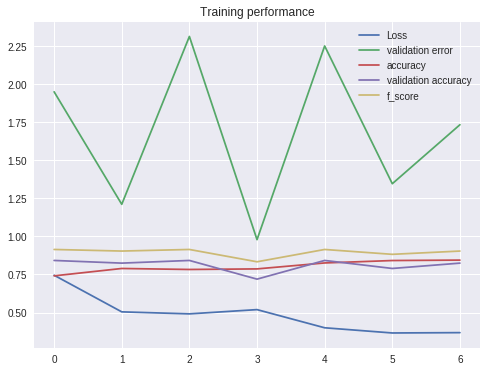

In [0]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an abnormal tear or not 
axial_abnormal_model = fit_model2(training_set_axial, training_label_abnormal, "axial_abnormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6046 - acc: 0.7819 - val_loss: 1.3688 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.6519 - acc: 0.7188

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.4726 - acc: 0.8034 - val_loss: 0.9485 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4693 - acc: 0.8127 - val_loss: 1.5979 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4114 - acc: 0.8276 - val_loss: 1.8333 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4196 - acc: 0.8313 - val_loss: 1.8349 - val_acc: 0.8421
-val_f1 : 0.000000 


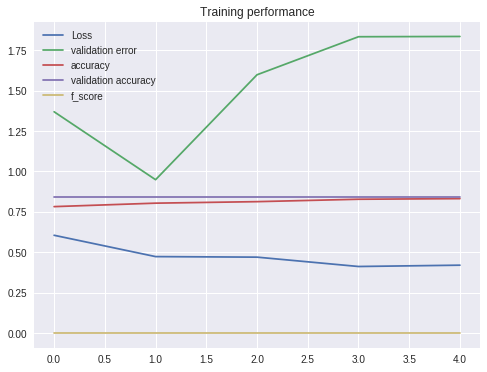

In [0]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an acl tear or not 
axial_acl_model = fit_model2(training_set_axial, training_label_acl, "axial_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6739 - acc: 0.6505 - val_loss: 1.1731 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.5649 - acc: 0.7188

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.5903 - acc: 0.6934 - val_loss: 1.2215 - val_acc: 0.6842
-val_f1 : 0.400000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5974 - acc: 0.6710 - val_loss: 1.3562 - val_acc: 0.6316
-val_f1 : 0.086957 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5609 - acc: 0.7092 - val_loss: 1.1594 - val_acc: 0.6667
-val_f1 : 0.512821 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5627 - acc: 0.7120 - val_loss: 2.7350 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5753 - acc: 0.6999 - val_loss: 1.7573 - val_acc: 0.6491
-val_f1 : 0.285714 
Epoch 7/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5655 - acc: 0.7083 - val_loss: 1.1494 - val_acc: 0.5789
-val_f1 : 0.538462 
Epoch 8/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5393 - ac

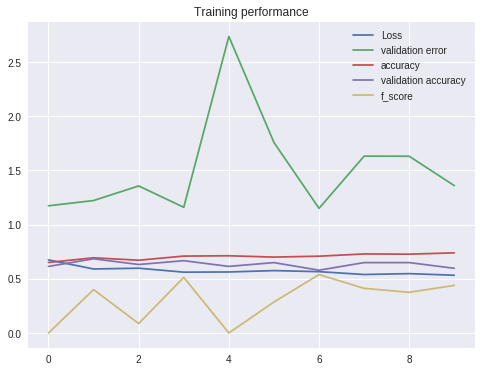

In [0]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has a meniscus tear or not 
axial_meniscus_model = fit_model2(training_set_axial, training_label_meniscus, "axial_meniscus_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5165 - acc: 0.7791 - val_loss: 1.2942 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4605 - acc: 0.8089 - val_loss: 1.4683 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4135 - acc: 0.8127 - val_loss: 0.9535 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3946 - acc: 0.8034 - val_loss: 1.5497 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3907 - acc: 0.8062 - val_loss: 1.7496 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3551 - acc: 0.8248 - val_loss: 2.0481 - val_acc: 0.8421
-val_f1 : 0.914286 


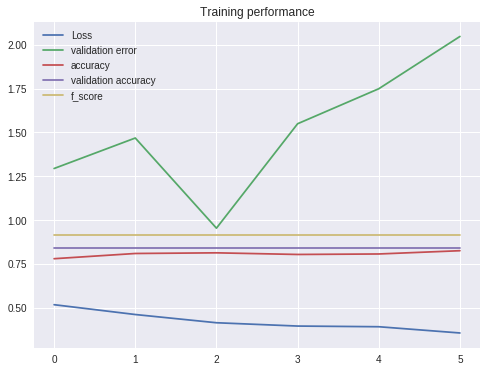

In [0]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an abnormal tear or not 
coronal_abnormal_model = fit_model2(training_set_coronal, training_label_abnormal, "coronal_abnormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5664 - acc: 0.7875 - val_loss: 1.1491 - val_acc: 0.8421


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5084 - acc: 0.8145 - val_loss: 1.6462 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4874 - acc: 0.8145 - val_loss: 1.6189 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4974 - acc: 0.8145 - val_loss: 0.9538 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4903 - acc: 0.8145 - val_loss: 1.0923 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4881 - acc: 0.8145 - val_loss: 1.3405 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 7/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4867 - acc: 0.8145 - val_loss: 1.3782 - val_acc: 0.8421
-val_f1 : 0.000000 


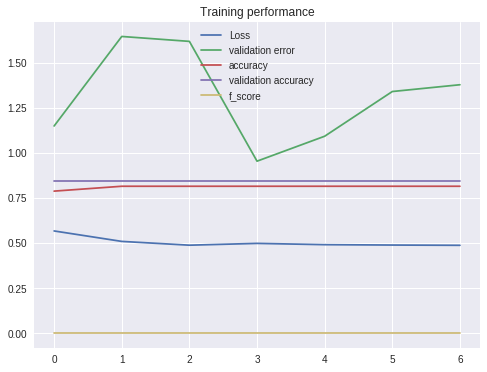

In [0]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an acl tear or not 
coronal_acl_model = fit_model2(training_set_coronal, training_label_acl, "coronal_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6481 - acc: 0.6505 - val_loss: 1.6396 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.5691 - acc: 0.7500

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.6151 - acc: 0.6598 - val_loss: 2.2550 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6147 - acc: 0.6542 - val_loss: 2.4030 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5974 - acc: 0.6664 - val_loss: 3.2045 - val_acc: 0.6140
-val_f1 : 0.000000 


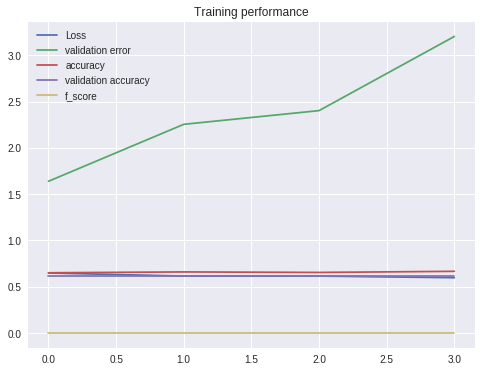

In [0]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has a meniscus tear or not 
coronal_meniscus_model = fit_model2(training_set_coronal, training_label_meniscus, "coronal_meniscus_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5570 - acc: 0.7465 - val_loss: 1.0596 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4722 - acc: 0.8062 - val_loss: 0.6113 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4481 - acc: 0.8108 - val_loss: 0.9096 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3985 - acc: 0.8276 - val_loss: 0.9255 - val_acc: 0.8246
-val_f1 : 0.901961 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3808 - acc: 0.8378 - val_loss: 0.9157 - val_acc: 0.5263
-val_f1 : 0.649351 


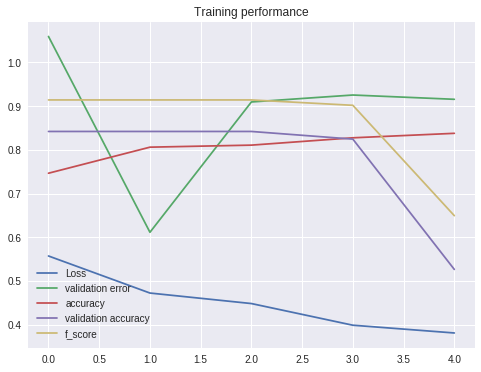

In [0]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an abnormal tear or not 
sagittal_abnormal_model = fit_model2(training_set_sagittal, training_label_abnormal, "sagittal_abormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5274 - acc: 0.7931 - val_loss: 1.0896 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.4490 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.4937 - acc: 0.8145 - val_loss: 1.6744 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4861 - acc: 0.8145 - val_loss: 1.3125 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4887 - acc: 0.8145 - val_loss: 1.6482 - val_acc: 0.8421
-val_f1 : 0.000000 


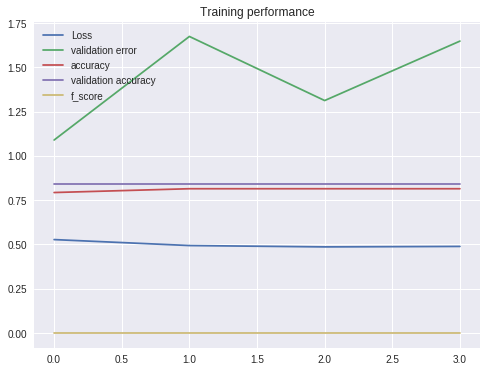

In [0]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an acl tear or not 
sagittal_acl_model = fit_model2(training_set_sagittal, training_label_acl, "sagittal_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6548 - acc: 0.6570 - val_loss: 1.3852 - val_acc: 0.6140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6220 - acc: 0.6561 - val_loss: 0.7793 - val_acc: 0.5614
-val_f1 : 0.489796 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6019 - acc: 0.6570 - val_loss: 1.9022 - val_acc: 0.5965
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5808 - acc: 0.6841 - val_loss: 1.2882 - val_acc: 0.5789
-val_f1 : 0.294118 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5752 - acc: 0.6878 - val_loss: 1.8306 - val_acc: 0.5965
-val_f1 : 0.000000 


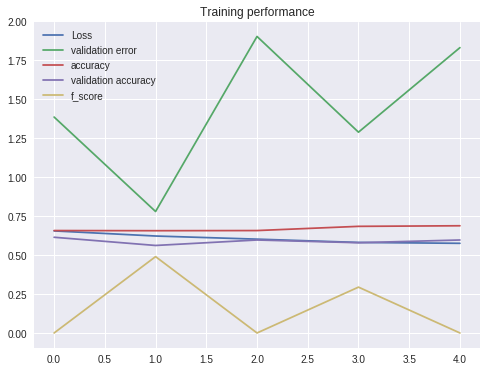

In [0]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has a meniscus tear or not 
sagittal_meniscus_model = fit_model2(training_set_sagittal, training_label_meniscus, "sagittal_meniscus_model")

In [0]:
#load the test data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def testSet(file_name):
    test_set = []
    for np_name in sorted(glob.glob('/content/drive/My Drive/MRNET/MRNet-v1.0/valid/'+file_name+'/*.npy')):
        test_set.append(np.load(np_name))
    return test_set   

In [0]:
#load the test data for each angle of the knee
test_set_axial= testSet('axial')
test_set_coronal=testSet('coronal')
test_set_sagittal=testSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
test_set_axial = extract_3(test_set_axial, 120)
test_set_coronal =extract_3(test_set_coronal, 120)
test_set_sagittal =extract_3(test_set_sagittal, 120)

In [0]:
#load the labels of the test data for each knee tear 
test_label_abnormal = load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/valid-abnormal.csv')
test_label_acl = load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/valid-acl.csv')
test_label_meniscus = load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/valid-meniscus.csv')

In [0]:
axial_abnormal_model.evaluate(test_set_axial, test_label_abnormal)

120/120 [==============================] - 36s 296ms/step


[2.620534899534444, 0.7916666666666666]

In [0]:
axial_acl_model.evaluate(test_set_axial, test_label_acl) 

120/120 [==============================] - 36s 298ms/step


[4.1630372505635025, 0.55]

In [0]:
axial_meniscus_model.evaluate(test_set_axial, test_label_meniscus) 

120/120 [==============================] - 35s 294ms/step


[1.2801123062769573, 0.5500000002483527]

In [0]:
coronal_abnormal_model.evaluate(test_set_coronal, test_label_abnormal)

120/120 [==============================] - 35s 295ms/step


[1.7501238999771886, 0.7916666666666666]

In [0]:
coronal_acl_model.evaluate(test_set_coronal, test_label_acl)

120/120 [==============================] - 36s 296ms/step


[3.530718553562959, 0.55]

In [0]:
coronal_meniscus_model.evaluate(test_set_coronal, test_label_meniscus)

120/120 [==============================] - 36s 297ms/step


[1.8160638789335886, 0.5666666666666667]

In [0]:
sagittal_abnormal_model.evaluate(test_set_sagittal, test_label_abnormal)

120/120 [==============================] - 36s 302ms/step


[1.6186912363317485, 0.7916666666666666]

In [0]:
sagittal_acl_model.evaluate(test_set_sagittal, test_label_acl)

120/120 [==============================] - 37s 305ms/step


[2.8889908686280252, 0.55]

In [0]:
sagittal_meniscus_model.evaluate(test_set_sagittal, test_label_meniscus)

120/120 [==============================] - 37s 305ms/step


[1.4990095178286234, 0.5666666666666667]

#Features Extraction Model


In [0]:
def features_extractor(exam,model):
  
  #NASnet extractor
  exam_rgb = add_rgb(exam)
  features = model.predict(exam_rgb)
  
  #Max Pooling
  pool = Sequential()
  pool.build(input_shape=(None,)+features.shape)
  pool.add(GlobalMaxPooling1D())
  max_features = pool.predict(np.array([features,]))
  max_features = max_features.reshape(-1)
  
  #Clearing Temp RAM
  exam_rgb = None
  features = None
  pool = None
  
  
  return max_features




## Loading Data, Saving Features and Labels Function

In [0]:
def load_data(path):
  data = []
  for d in sorted(os.listdir(path)):
    if d!='.DS_Store':
      img = np.load(os.path.join(path,d))
      img = img.astype(np.uint8)
      img_aug = augment(img)
      feature_vec = features_extractor(img_aug,model)
      data.append(feature_vec)
      print("in iterator ", d)
      clear()
  return data

def load_labels(path):
  labels = []
  read = pd.read_csv(path, names=['num', 'hot'])
  labels = list(read['hot'])
  return labels

##Image Augementation

In [0]:
def augment(image):
  aug=[]
  for s in range(len(image)):
      aug.append(ia.imresize_single_image(image[s], (224, 224)))
  aug=np.array(aug)
  return aug

def clear():
  aug= None
  gc.collect()


###**Adding Extra Dimensions to make it (s X 227 X 227 X 3)**

In [0]:
def add_rgb(grey_img):
  rgb_img = np.repeat(grey_img[..., np.newaxis], 3, -1)
  return rgb_img

##Load Training Data *(Load only when you want to change features)*

In [0]:
train_axial_dir='/content/drive/My Drive/MRNET/MRNet-v1.0/train/axial'
train_coronal_dir= '/content/drive/My Drive/MRNET/MRNet-v1.0/train/coronal'
train_sagittal_dir= '/content/drive/My Drive/MRNET/MRNet-v1.0/train/sagittal'
train_abnormal_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/train-abnormal.csv'
train_acl_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/train-acl.csv'
train_meniscus_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/train-meniscus.csv'

print("**************     load axial   **************** ")
train_axial_data = np.array(load_data(train_axial_dir))
write_features('train_axial_features.csv' , train_axial_data)

print("**************     load cronal   **************** ")
train_coronal_data = np.array(load_data(train_coronal_dir))
write_features('train_coronal_features.csv' , train_coronal_data)

print("**************     load sagital   **************** ")
train_sagittal_data = np.array(load_data(train_sagittal_dir))
write_features('train_sagittal_features.csv' , train_sagittal_data)


print(train_axial_data.shape)
print(train_coronal_data.shape)
print(train_sagittal_data.shape)



##Write the Extraxted Features in File *(Run only when changing Pretrained model)*

In [0]:
def write_features(filename , features):
  with open(filename, 'w') as writeFile:
    writer = csv.writer(writeFile , delimiter='#')
    writer.writerows(features)
  writeFile.close()
  

#Load Validation data  (Only if new features)

In [0]:

val_axial_dir = '/content/drive/My Drive/MRNET/MRNet-v1.0/valid/axial'
val_coronal_dir = '/content/drive/My Drive/MRNET/MRNet-v1.0/valid/coronal'
val_sagittal_dir = '/content/drive/My Drive/MRNET/MRNet-v1.0/valid/sagittal'
val_abnormal_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/valid-abnormal.csv'
val_acl_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/valid-acl.csv'
val_meniscus_labels= '/content/drive/My Drive/MRNET/MRNet-v1.0/valid-meniscus.csv'

val_axial_data = np.array(load_data(val_axial_dir))
write_features('val_axial_features.csv' , val_axial_data)

val_coronal_data = np.array(load_data(val_coronal_dir))
write_features('val_coronal_features.csv' , val_coronal_data)

val_sagittal_data = np.array(load_data(val_sagittal_dir))
write_features('val_sagittal_features.csv' , val_sagittal_data)


print(val_axial_data.shape)
print(val_coronal_data.shape)
print(val_sagittal_data.shape)

*************************************************************************************
##If no edit in CSV Features Files , we can start running the code from the next block
*************************************************************************************

#Load Extracted Features

In [0]:
def load_extracted_features(path):
  with open(path, newline='') as f:
    reader = csv.reader(f, delimiter='#', quoting=csv.QUOTE_NONE)
    reconst=[]
    for row in reader:
        reconst.append(list(map(float,row)))
return np.array(reconst)
  

In [0]:

axial_features = load_extracted_features('train_axial_features.csv')
coronal_features = load_extracted_features('train_coronal_features.csv')
sagittal_features = load_extracted_features('train_sagittal_features.csv')


print(axial_features.shape)
print(coronal_features.shape)
print(sagittal_features.shape)



(1130, 1056)
(1130, 1056)
(1130, 1056)
[0.1544396  0.48544857 0.         ... 0.54405844 3.2593782  0.        ]
[0.         0.38965356 0.23772204 ... 0.         0.08875852 0.        ]
[0.         0.25440466 0.         ... 0.         0.17740119 0.        ]


#Load Validation Features

In [0]:
val_axial_features = load_extracted_features('val_train_axial_features.csv')
val_coronal_features = load_extracted_features('val_train_coronal_features.csv')
val_sagittal_features = load_extracted_features('val_train_sagittal_features.csv')


print(axial_features.shape)
print(coronal_features.shape)
print(sagittal_features.shape)

##**Load Test and Validation Labels**


In [0]:
train_abnormal_labels= load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/train-abnormal.csv')
train_meniscus_labels= load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/train-meniscus.csv')
train_acl_labels= load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/train-acl.csv')

val_abnormal_labels= np.array(load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/valid-abnormal.csv'))
val_meniscus_labels= np.array(load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/valid-meniscus.csv'))
val_acl_labels= np.array(load_labels('/content/drive/My Drive/MRNET/MRNet-v1.0/valid-acl.csv'))

#Model

In [0]:
from keras.constraints import max_norm
from keras import optimizers
from keras.layers import Input, Dense
def model():
  a = Input(shape=(1056,))
  my_model = Dense(256, activation ='relu',kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0))(a)
  predictions=Dense(1, activation ='sigmoid')(my_model)


  my_model = Model(inputs=a, outputs=predictions)

  sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  my_model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return my_model

Compute average

In [0]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [0]:
batchSize=250
epoch=300

In [0]:
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

#Plotting

In [0]:
def plot_graphs(y):
  plt.plot( epochs,y.history['acc'],'r')
  plt.xlabel("Epochs")
  plt.ylabel("acc")
  plt.title("Accuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_acc'],'b')
  plt.xlabel("Epochs")
  plt.ylabel("val_acc")
  plt.title("Vlidation Acuuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['loss'],'g')
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.title("Loss vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_loss'],'k')
  plt.xlabel("Epochs")
  plt.ylabel("val_loss")
  plt.title("Validation Loss vs Epochs")
  plt.show()

# Train Using Built-In Methods you can change the model using (model(), model1(), model2(), model3())

**Axial features, Abnormal labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 10s 10ms/step - loss: 1.0829 - acc: 0.7290 - val_loss: 0.4554 - val_acc: 0.7941
Epoch 2/300
1096/1096 [==============================] - 0s 45us/step - loss: 0.6899 - acc: 0.7719 - val_loss: 0.5773 - val_acc: 0.7647
Epoch 3/300
1096/1096 [==============================] - 0s 36us/step - loss: 0.9060 - acc: 0.7354 - val_loss: 0.5809 - val_acc: 0.6765
Epoch 4/300
1096/1096 [==============================] - 0s 36us/step - loss: 0.7097 - acc: 0.7427 - val_loss: 0.3514 - val_acc: 0.8824
Epoch 5/300
1096/1096 [==============================] - 0s 36us/step - loss: 0.5154 - acc: 0.7883 - val_loss: 0.3988 - val_acc: 0.9118
Epoch 6/300
1096/1096 [==============================] - 0s 38us/step - loss: 0.4549 - acc: 0.7883 - val_loss: 0.3579 - val_acc: 0.8824
Epoch 7/300
1096/1096 [==============================] - 0s 38us/step - loss: 0.4610 - acc: 0.7956 - val_loss: 0.3997 - val_acc: 0.9118
E

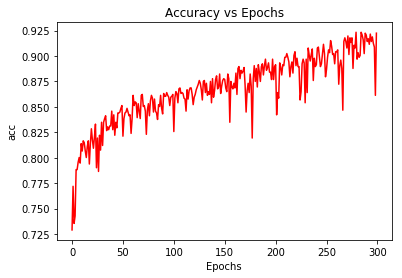

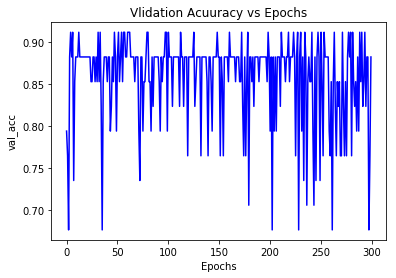

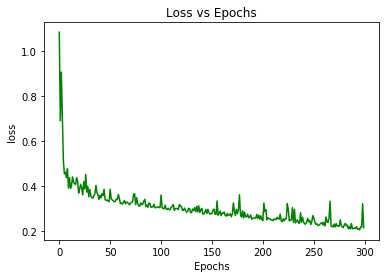

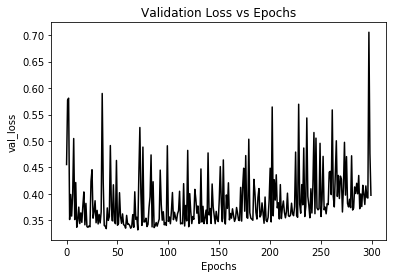

In [0]:
abnormalAccuracys=[]
axial_abnormal = model().fit(axial_features, train_abnormal_labels, epochs = epoch, shuffle=True , validation_split = 0.10, batch_size = batchSize)
#axial_abnormal = model().fit(axial_features, train_abnormal_labels,epochs=epoch, shuffle=True,validation_data=(val_axial_features, val_abnormal_labels), batch_size = batchSize)


abnormalAccuracys.append(Average(axial_abnormal.history['val_acc']))
plot_graphs(axial_abnormal)



**Coronal features, Abnormal labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 11s 10ms/step - loss: 1.0397 - acc: 0.7026 - val_loss: 0.3935 - val_acc: 0.7647
Epoch 2/300
1096/1096 [==============================] - 0s 40us/step - loss: 0.5401 - acc: 0.7591 - val_loss: 0.3505 - val_acc: 0.8824
Epoch 3/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.4971 - acc: 0.8029 - val_loss: 0.5245 - val_acc: 0.8529
Epoch 4/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.4903 - acc: 0.7901 - val_loss: 0.3599 - val_acc: 0.8824
Epoch 5/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.4592 - acc: 0.8066 - val_loss: 0.3566 - val_acc: 0.8824
Epoch 6/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.4520 - acc: 0.8057 - val_loss: 0.4035 - val_acc: 0.8824
Epoch 7/300
1096/1096 [==============================] - 0s 29us/step - loss: 0.4421 - acc: 0.8102 - val_loss: 0.3881 - val_acc: 0.8824
E

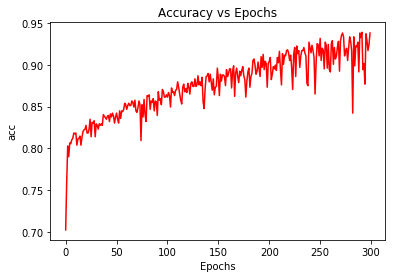

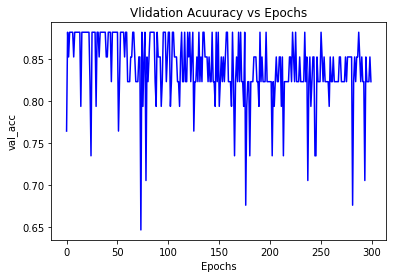

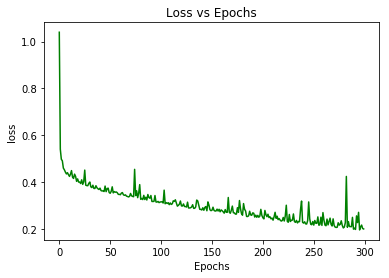

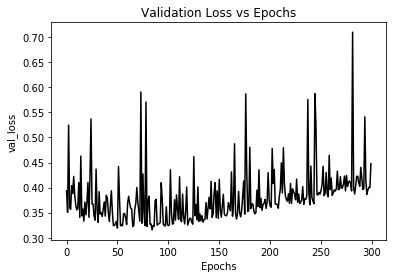

In [0]:
coronal_abnormal = model().fit(coronal_features, train_abnormal_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)
#coronal_abnormal = model().fit(coronal_features, train_abnormal_labels,epochs=epoch,shuffle=True,validation_data=(val_coronal_features, val_abnormal_labels), batch_size = batchSize)

abnormalAccuracys.append(Average(coronal_abnormal.history['val_acc']))
plot_graphs(coronal_abnormal)


**Sagittal features, Abnormal labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 11s 10ms/step - loss: 0.9696 - acc: 0.7126 - val_loss: 0.4329 - val_acc: 0.8824
Epoch 2/300
1096/1096 [==============================] - 0s 38us/step - loss: 0.6939 - acc: 0.7546 - val_loss: 0.4045 - val_acc: 0.8824
Epoch 3/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.4921 - acc: 0.7984 - val_loss: 0.7661 - val_acc: 0.5294
Epoch 4/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.7030 - acc: 0.7400 - val_loss: 0.3324 - val_acc: 0.8529
Epoch 5/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.4459 - acc: 0.8075 - val_loss: 0.4509 - val_acc: 0.8235
Epoch 6/300
1096/1096 [==============================] - 0s 38us/step - loss: 0.4443 - acc: 0.8084 - val_loss: 0.3247 - val_acc: 0.8529
Epoch 7/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.4141 - acc: 0.8157 - val_loss: 0.3329 - val_acc: 0.8529
E

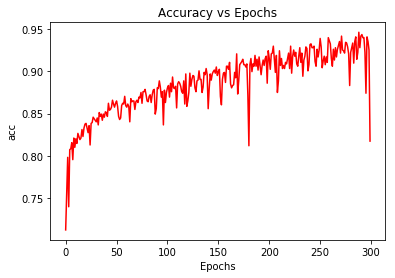

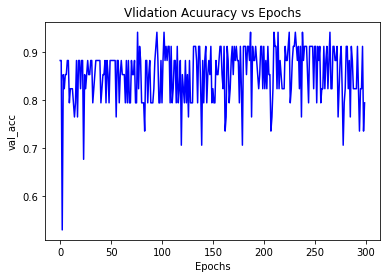

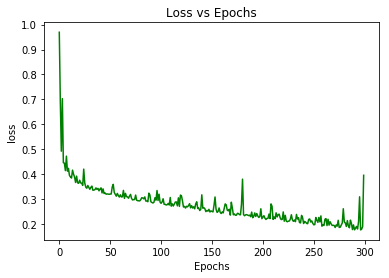

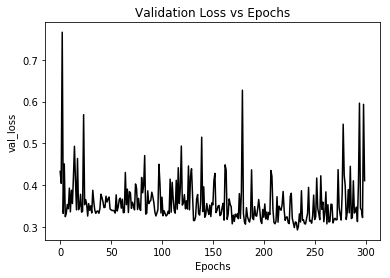

In [0]:
sagittal_abnormal = model().fit(sagittal_features, train_abnormal_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

abnormalAccuracys.append(Average(sagittal_abnormal.history['val_acc']))

plot_graphs(sagittal_abnormal)

**Axial features, acl labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 0.6522 - acc: 0.7673 - val_loss: 0.6969 - val_acc: 0.5882
Epoch 2/300
1096/1096 [==============================] - 0s 38us/step - loss: 0.8419 - acc: 0.7044 - val_loss: 0.5757 - val_acc: 0.8529
Epoch 3/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.8720 - acc: 0.7254 - val_loss: 0.6201 - val_acc: 0.6765
Epoch 4/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.5195 - acc: 0.7938 - val_loss: 0.4738 - val_acc: 0.8235
Epoch 5/300
1096/1096 [==============================] - 0s 29us/step - loss: 0.4711 - acc: 0.8102 - val_loss: 0.4236 - val_acc: 0.8235
Epoch 6/300
1096/1096 [==============================] - 0s 29us/step - loss: 0.4609 - acc: 0.8139 - val_loss: 0.4107 - val_acc: 0.8235
Epoch 7/300
1096/1096 [==============================] - 0s 29us/step - loss: 0.4423 - acc: 0.8148 - val_loss: 0.4469 - val_acc: 0.8235
E

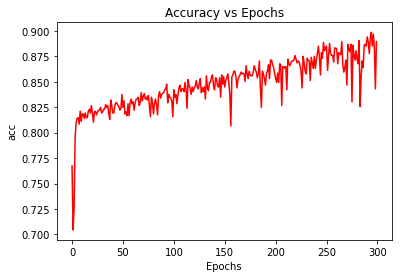

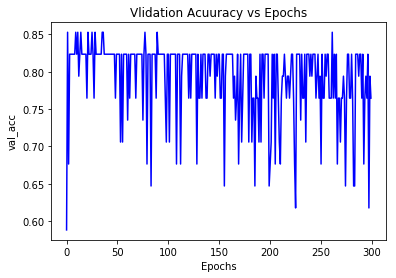

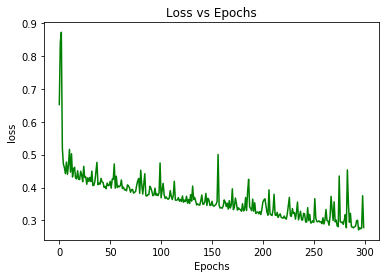

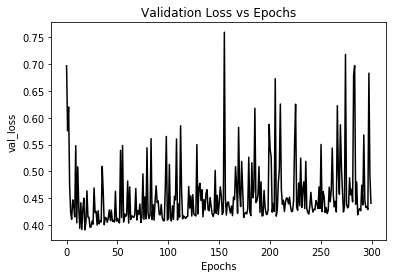

In [0]:
aclAccuracys=[]
axial_acl = model().fit(axial_features, train_acl_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

aclAccuracys.append(Average(axial_acl.history['val_acc'])) 
plot_graphs(axial_acl)

**Coronal features, Acl labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 0.6022 - acc: 0.7801 - val_loss: 0.4993 - val_acc: 0.8529
Epoch 2/300
1096/1096 [==============================] - 0s 43us/step - loss: 0.8709 - acc: 0.7354 - val_loss: 0.4281 - val_acc: 0.8529
Epoch 3/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.5615 - acc: 0.7673 - val_loss: 0.9059 - val_acc: 0.8529
Epoch 4/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.7231 - acc: 0.7874 - val_loss: 1.2911 - val_acc: 0.2647
Epoch 5/300
1096/1096 [==============================] - 0s 33us/step - loss: 1.9638 - acc: 0.6898 - val_loss: 0.7306 - val_acc: 0.8529
Epoch 6/300
1096/1096 [==============================] - 0s 30us/step - loss: 1.0128 - acc: 0.6670 - val_loss: 0.4675 - val_acc: 0.8529
Epoch 7/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.5284 - acc: 0.7984 - val_loss: 0.3899 - val_acc: 0.8529
E

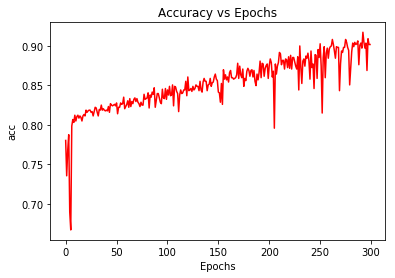

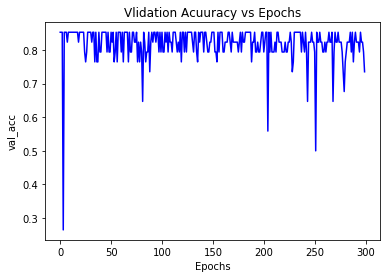

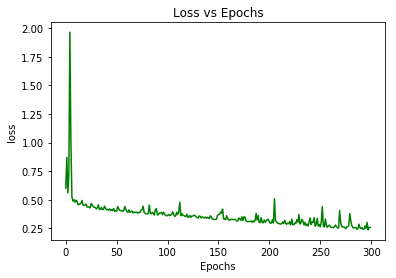

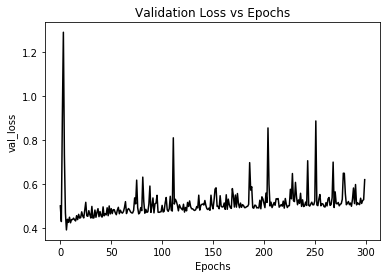

In [0]:
coronal_acl = model().fit(coronal_features, train_acl_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

aclAccuracys.append(Average(coronal_acl.history['val_acc'])) 
plot_graphs(coronal_acl)

**Sagittal features, Acl labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 2.2374 - acc: 0.6898 - val_loss: 1.3772 - val_acc: 0.8529
Epoch 2/300
1096/1096 [==============================] - 0s 39us/step - loss: 1.0660 - acc: 0.7080 - val_loss: 0.5005 - val_acc: 0.7647
Epoch 3/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.5334 - acc: 0.8011 - val_loss: 0.6961 - val_acc: 0.6471
Epoch 4/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.5539 - acc: 0.7682 - val_loss: 0.4179 - val_acc: 0.8529
Epoch 5/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.4776 - acc: 0.8139 - val_loss: 0.3975 - val_acc: 0.8529
Epoch 6/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.4803 - acc: 0.8066 - val_loss: 0.3954 - val_acc: 0.8529
Epoch 7/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.4907 - acc: 0.8093 - val_loss: 0.3841 - val_acc: 0.8235
E

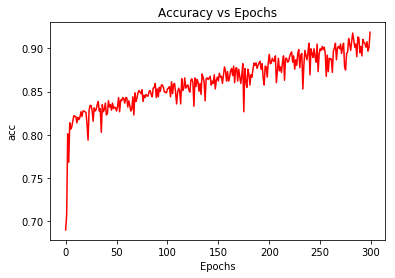

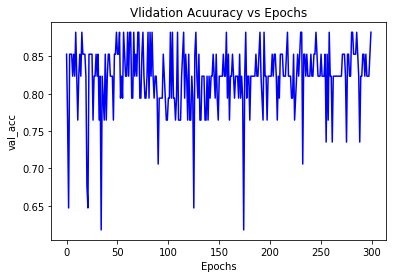

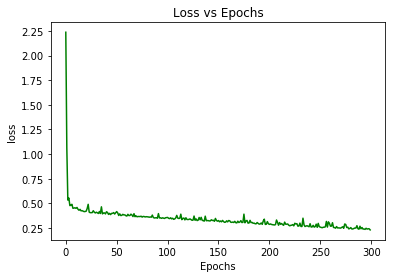

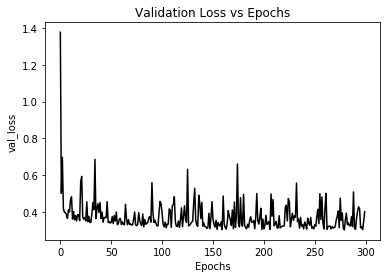

In [0]:
sagittal_acl = model().fit(sagittal_features, train_acl_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

aclAccuracys.append(Average(sagittal_acl.history['val_acc'])) 
plot_graphs(sagittal_acl)

**Axial features, Meniscus labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 1.8762 - acc: 0.5493 - val_loss: 1.5418 - val_acc: 0.5588
Epoch 2/300
1096/1096 [==============================] - 0s 38us/step - loss: 1.2542 - acc: 0.5684 - val_loss: 1.4485 - val_acc: 0.5588
Epoch 3/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.7396 - acc: 0.6597 - val_loss: 0.7530 - val_acc: 0.5000
Epoch 4/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.6146 - acc: 0.6743 - val_loss: 0.7160 - val_acc: 0.5882
Epoch 5/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.7420 - acc: 0.6305 - val_loss: 0.7875 - val_acc: 0.5882
Epoch 6/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.6314 - acc: 0.6505 - val_loss: 0.7074 - val_acc: 0.5882
Epoch 7/300
1096/1096 [==============================] - 0s 30us/step - loss: 0.6172 - acc: 0.6606 - val_loss: 1.1071 - val_acc: 0.5588
E

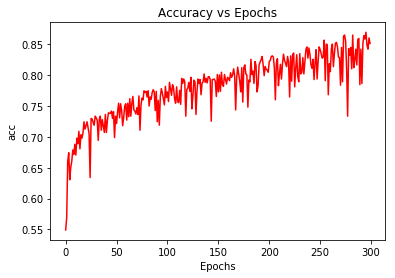

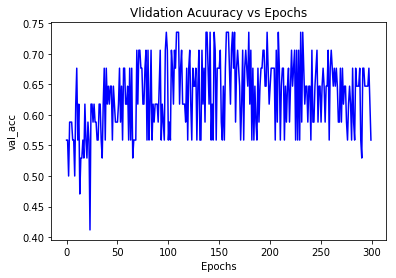

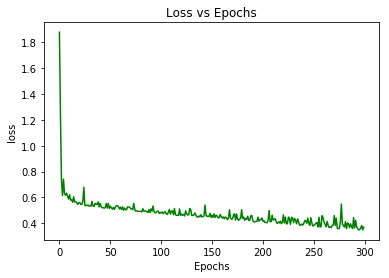

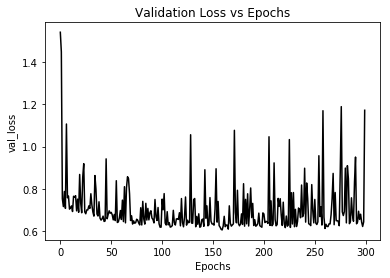

In [0]:
meniscusAccuracys=[]
axial_meniscus = model().fit(axial_features, train_meniscus_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

meniscusAccuracys.append(Average(axial_meniscus.history['val_acc'])) 
plot_graphs(axial_meniscus)

**Coronal features, Meniscus labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 1.0614 - acc: 0.6031 - val_loss: 1.0697 - val_acc: 0.4706
Epoch 2/300
1096/1096 [==============================] - 0s 42us/step - loss: 1.3108 - acc: 0.5328 - val_loss: 0.9737 - val_acc: 0.5000
Epoch 3/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.8011 - acc: 0.5849 - val_loss: 0.8045 - val_acc: 0.4706
Epoch 4/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.6653 - acc: 0.6250 - val_loss: 0.8501 - val_acc: 0.4412
Epoch 5/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.9100 - acc: 0.5429 - val_loss: 1.2607 - val_acc: 0.5588
Epoch 6/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.6654 - acc: 0.6442 - val_loss: 1.0836 - val_acc: 0.5588
Epoch 7/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.6805 - acc: 0.6277 - val_loss: 0.8070 - val_acc: 0.4412
E

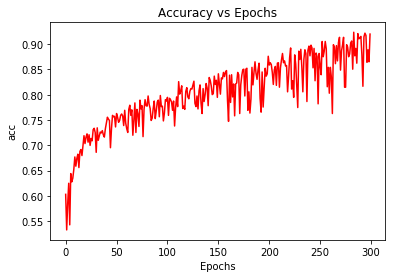

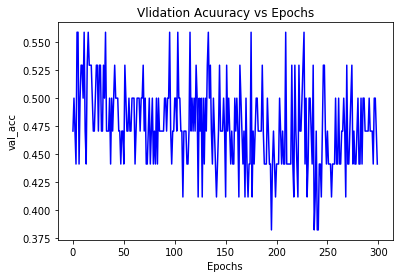

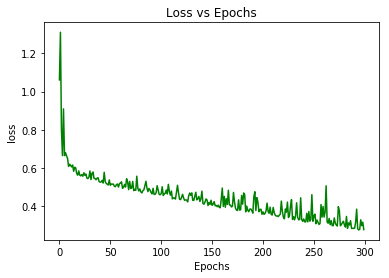

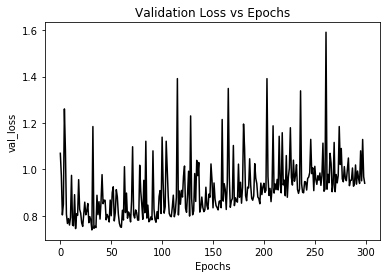

In [0]:
coronal_meniscus = model().fit(coronal_features, train_meniscus_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

meniscusAccuracys.append(Average(coronal_meniscus.history['val_acc'])) 
plot_graphs(coronal_meniscus)

**Sagittal features, Meniscus labels**

Train on 1096 samples, validate on 34 samples
Epoch 1/300
1096/1096 [==============================] - 12s 11ms/step - loss: 1.4686 - acc: 0.5429 - val_loss: 3.2739 - val_acc: 0.4412
Epoch 2/300
1096/1096 [==============================] - 0s 40us/step - loss: 1.8988 - acc: 0.4909 - val_loss: 1.2248 - val_acc: 0.3529
Epoch 3/300
1096/1096 [==============================] - 0s 33us/step - loss: 0.9351 - acc: 0.5520 - val_loss: 1.3193 - val_acc: 0.5588
Epoch 4/300
1096/1096 [==============================] - 0s 32us/step - loss: 0.7283 - acc: 0.6423 - val_loss: 0.8916 - val_acc: 0.4118
Epoch 5/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.6402 - acc: 0.6478 - val_loss: 0.8258 - val_acc: 0.4412
Epoch 6/300
1096/1096 [==============================] - 0s 31us/step - loss: 0.6159 - acc: 0.6661 - val_loss: 0.8468 - val_acc: 0.5000
Epoch 7/300
1096/1096 [==============================] - 0s 29us/step - loss: 0.5987 - acc: 0.6880 - val_loss: 1.0320 - val_acc: 0.5588
E

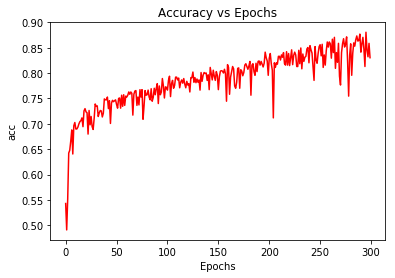

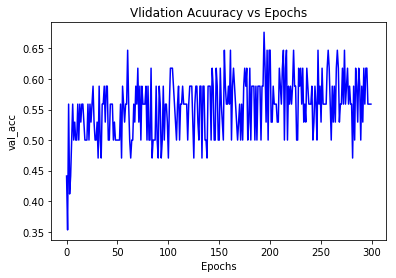

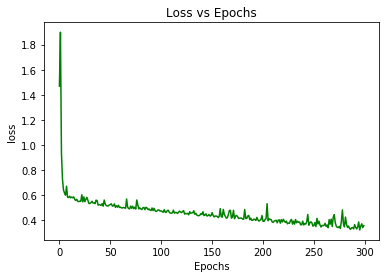

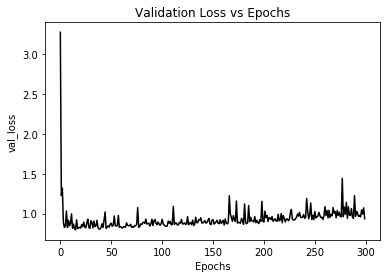

In [0]:
sagittal_meniscus = model().fit(sagittal_features, train_meniscus_labels, epochs = epoch, shuffle=True , validation_split = 0.03, batch_size = batchSize)

meniscusAccuracys.append(Average(sagittal_meniscus.history['val_acc'])) 
plot_graphs(sagittal_meniscus)


# Calculate The Accuracy Using Built-In Models.

In [0]:
print(len(abnormalAccuracys))
print(len(meniscusAccuracys))
print(len(aclAccuracys))


3
3
3


In [0]:
# For built-In Models
print("Accuracy Abnormal = ",Average(abnormalAccuracys)*100,"%")
print("Accuracy Meniscus = ",Average(meniscusAccuracys)*100,"%")
print("Accuracy Acl = ",Average(aclAccuracys)*100,"%")

Accuracy Abnormal =  85.08496701055103 %
Accuracy Meniscus =  55.398693366183174 %
Accuracy Acl =  81.12091491619746 %


# Calculate The Accuracy Using The Modified Models. ((Voting Criteria))

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an abnromal tear or not
#by doing a majority voting between the 3 models
def predict_abnormal(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_abnormal_prediction = axial_abnormal_model.predict(axial_input)
    coronal_abnormal_prediction = coronal_abnormal_model.predict(coronal_input)
    sagittal_abnormal_prediction = sagittal_abnormal_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_abnormal_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an acl tear or not
#by doing a majority voting between the 3 models
def predict_acl(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_acl_prediction = axial_acl_model.predict(axial_input)
    coronal_acl_prediction = coronal_acl_model.predict(coronal_input)
    sagittal_acl_prediction = sagittal_acl_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_acl_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an meniscus tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an meniscus tear or not
#by doing a majority voting between the 3 models
def predict_meniscus(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_meniscus_prediction = axial_meniscus_model.predict(axial_input)
    coronal_meniscus_prediction = coronal_meniscus_model.predict(coronal_input)
    sagittal_meniscus_prediction = sagittal_meniscus_model.predict(sagittal_input)
    
    #to say that the exam has the meniscus tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_meniscus_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_meniscus_model vote for the final decision 
        if(axial_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_meniscus_model vote for the final decision 
        if(coronal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_meniscus_model vote for the final decision 
        if(sagittal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
# For Modified Models.
#evaluate the abnormal ensemble models
print (predict_abnormal(test_set_axial, test_set_coronal, test_set_sagittal, test_label_abnormal))

79.16666666666666


In [0]:
# For Modified Models.
#evaluate the acl ensemble models
print (predict_acl(test_set_axial, test_set_coronal, test_set_sagittal, test_label_acl))

55.00000000000001


In [0]:
# For Modified Models.
#evaluate the meniscus ensemble models
print (predict_meniscus(test_set_axial, test_set_coronal, test_set_sagittal, test_label_meniscus))

56.666666666666664
